# Predicting heart disease using a patient’s age, maximum heart rate and ST depression
## Introduction
Given our preliminary data exploration conducted with this data set, we chose to use 4 variables in order to build a classifier that will be designed to predict whether or not a patient has heart disease. However, due to our limited knowledge at this time, we are not able to use the "thal" variable 
(indicating status of the patient's thalassemia (a blood disorder)) since it is a categorical variable and can't be used in a KNN classifier. As such we will be using the following 3 numerical variables to build our KNN classifier:
* Maximum heart rate achieved by the patient (bpm)
* Age of patient
* ST depression (measured by ECG)
These variables were chosen as they were found to have some sort of association with our response variable (diagnosis). The question we are trying to answer with this predictive data analysis is, given the stated variables, does that person have heart disease?
## Methods
First, we load the tidyverse package to be able to perform data analysis and visualization, along with the tidymodels package which is used for classification. We also load the gridExtra package which is used for our visualisations. This data anylysis requires that the tidyverse, tidymodels, ggmosaic and gridExtra R packages be downloaded.

In [1]:
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(ggmosaic, lib.loc = "test")
set.seed(54321)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Next we read in the data from the file available on the web, first by unzipping the file and then accessing only the data set we want. Although the dataset was provided as a .data file from the original source, the file contains comma-separated values, so we use read_csv. Since the data has no column names, we will rename them all using information available at [https://archive.ics.uci.edu/dataset/45/heart+disease].

In [2]:
url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
heart_temp <- tempfile()
download.file(url, heart_temp)
data <- read_csv(unzip(heart_temp, "processed.cleveland.data"), col_names = FALSE, show_col_types = FALSE) |>
    rename(age = X1, sex = X2, chest_pain = X3, resting_blood_pressure = X4,
           cholesterol = X5, fasting_blood_sugar = X6,
           resting_ecg = X7, max_heart_rate = X8, exercise_angina = X9,
           st_depression = X10, slope = X11, major_vessels = X12, thal = X13,
           diagnosis = X14)
unlink(heart_temp)

Now since we don't want to use every variable in the data set, we will select only those that we selected during preliminary data analysis: age. maximum heart rate achieved, ST depression, and diagnosis. Also, the authors of the data have indicated that all values 1-4 of the diagnosis variable mean a positive diagnosis, and only 0 indicates a negative diagnosis, so we will combine values 1-4 into 1 to simplify the data because our goal is only to determine the presence of heart disease.

In [3]:
data_selected <- data |>
    select(age, max_heart_rate, st_depression, diagnosis) |>
    mutate(diagnosis = as_factor(diagnosis)) |>
    mutate(diagnosis = fct_recode(diagnosis, "1" = "2", "1" = "3", "1" = "4"))

cat("Table 1: Preview of the heart disease data set")
head(data_selected)

Table 1: Preview of the heart disease data set

age,max_heart_rate,st_depression,diagnosis
<dbl>,<dbl>,<dbl>,<fct>
63,150,2.3,0
67,108,1.5,1
67,129,2.6,1
37,187,3.5,0
41,172,1.4,0
56,178,0.8,0


The table above gives a sense of the data we are working with. Now we can split the data set (and easily drop NA values) into a training set, which will be used to build our classifier, and a testing set, which will be used to evaluate the classifier.

In [4]:
data_split <- data_selected |>
    mutate(diagnosis = fct_recode(diagnosis,
                                "Angiographic disease" = "1",
                                "Healthy" = "0")) |>
    initial_split(prop = 0.75, strata = diagnosis)

training_set <- training(data_split)
testing_set <- testing(data_split)

Before we begin the data analysis, a summary of the training data is presented below:

In [5]:
number_of_observations <- training_set |>
    group_by(diagnosis) |>
    summarize(count = n())

cat("Table 2: Number of patients in the data set that are healthy or have heart disease")
number_of_observations

mean_values <- training_set |>
    group_by(diagnosis) |>
    summarize(mean_age = mean(age), mean_max_maximum_heart_rate = mean(max_heart_rate), mean_st_depression = mean(st_depression))

cat("\n\nTable 3: Mean values of predictor variables for healthy vs. diagnosed patients")
mean_values

Table 2: Number of patients in the data set that are healthy or have heart disease

diagnosis,count
<fct>,<int>
Healthy,123
Angiographic disease,104




Table 3: Mean values of predictor variables for healthy vs. diagnosed patients

diagnosis,mean_age,mean_max_maximum_heart_rate,mean_st_depression
<fct>,<dbl>,<dbl>,<dbl>
Healthy,52.20325,158.7317,0.5609756
Angiographic disease,57.00000,140.3846,1.5730769


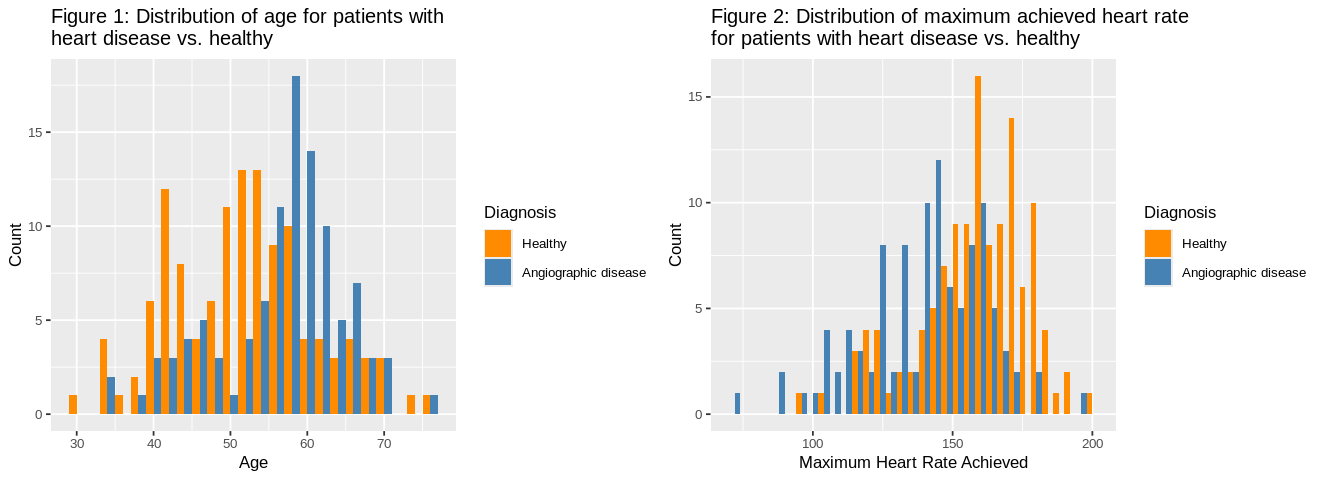

In [6]:
graph_age <- training_set |>
    ggplot(aes(x = age, fill = diagnosis)) +
    geom_histogram(position = "dodge", binwidth = 2) +
    labs(x = "Age", y = "Count", fill = "Diagnosis") +
    ggtitle("Figure 1: Distribution of age for patients with\nheart disease vs. healthy") +
    theme(text = element_text(size = 10)) +
    scale_fill_manual(values = c("darkorange", "steelblue"))

graph_heart_rate <- training_set |>
    ggplot(aes(x = max_heart_rate, fill = diagnosis)) +
    geom_histogram(position = "dodge", binwidth = 4) +
    labs(x = "Maximum Heart Rate Achieved", y = "Count", fill = "Diagnosis") +
    ggtitle("Figure 2: Distribution of maximum achieved heart rate\nfor patients with heart disease vs. healthy") +
    theme(text = element_text(size = 10)) +
    scale_fill_manual(values = c("darkorange", "steelblue"))

options(repr.plot.width = 11, repr.plot.height = 4)
grid.arrange(graph_age, graph_heart_rate, ncol = 2)

Now we will use cross-validation with 10 folds to determine the best K value to use for our K-nearest-neighbours classifier.

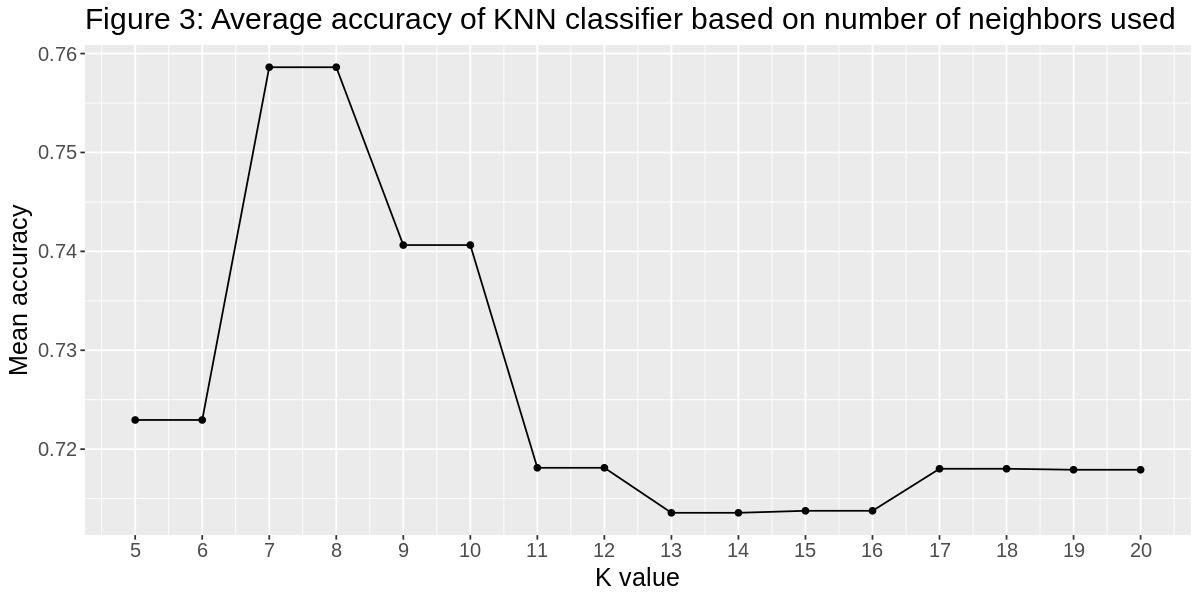

In [7]:
set.seed(54321)
knn_recipe <- recipe(diagnosis ~ ., data = training_set) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = 5:20)

vfold <- vfold_cv(training_set, v = 5, strata = diagnosis)

knn_fit_tuning <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec_tune) |>
    tune_grid(resamples = vfold, grid = k_vals)

tuning_metrics <- knn_fit_tuning |>
    collect_metrics()

tuning_accuracies <- filter(tuning_metrics, .metric == "accuracy")

cross_val_plot <- tuning_accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() +
    labs(x = "K value", y = "Mean accuracy") +
    ggtitle("Figure 3: Average accuracy of KNN classifier based on number of neighbors used") +
    theme(text = element_text(size = 15)) +
    scale_x_continuous(breaks = 5:30)

options(repr.plot.height = 5, repr.plot.width = 10)
cross_val_plot

From the above graph, we choose K to be 8 for the rest of our classifier. We chose 8 instead of 7 even though they have the same accuracy, since around a K of 8 (i.e. K = 7 and K = 9) the accuracies are higher than around K = 7 (i.e. there is a sudden drop off in accuracy when K = 6), so choosing a K where the K +/- 1 also results in similar accuracies provides some room for error that may be caused by variations.

Below we build the model and fit it to our data.

In [8]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(data = training_set)

Now we will evaluate our classifier using the testing set from the original data. To do this we first calculate the accuracy using the `metrics` function. The accuracy of a classifier represents the fraction of predictions for which the classifier makes the correct prediction, in other words,
$$\text{accuracy} = \text{number of correct predictions } / \text{ total predictions}.$$

Since we are particularly interested in classifying and identifying patients with heart disease, we set this as our "important"/"positive" class, allowing us to calculate precision and recall. Precision refers to how many of the positive predictions our classifier made were actually positive. Recall refers to how many of the positive cases in the testing set our classifier actually labelled as positive.

Precision is calculated as # of true positives / all positive predictions (i.e. true positives + false positives).

Recall is calculated as # of true positives / # of positive test data points (i.e. true positives + false negatives).

In [9]:
predictions <- predict(knn_fit, testing_set) |>
    bind_cols(testing_set)

accuracy <- predictions |>
    metrics(truth = diagnosis, estimate = .pred_class) |>
    filter(.metric == "accuracy")

cat("Order of diagnoses in the data set:")
predictions |> pull(diagnosis) |> levels()

precision <- predictions |>
  precision(truth = diagnosis, estimate = .pred_class, event_level = "second")

recall <- predictions |>
  recall(truth = diagnosis, estimate = .pred_class, event_level = "second")

metrics <- bind_rows(precision, recall, accuracy) |>
    mutate(Metric = .metric, "Value (%)" = .estimate * 100) |>
    select(Metric, "Value (%)")

cat("\n\nTable 4: Metrics for our classifier")
metrics

Order of diagnoses in the data set:

[1] "Healthy"              "Angiographic disease"



Table 4: Metrics for our classifier

Metric,Value (%)
<chr>,<dbl>
precision,58.33333
recall,60.00000
accuracy,61.84211


We also calculate the confusion matrix, which is a convenient way of analysing the types of predictions our classifier makes.

In [10]:
conf_mat <- predictions |>
    conf_mat(truth = diagnosis, estimate = .pred_class)

cat("\n\n")

cat("Table 4: Confusion matrix for KNN classifier with K = 8")
conf_mat



Table 4: Confusion matrix for KNN classifier with K = 8

                      Truth
Prediction             Healthy Angiographic disease
  Healthy                   26                   14
  Angiographic disease      15                   21

In [11]:
p = 21 / (21 + 15) # 0.583
r = 21 / (21 + 14) # 0.6

In order to visualize this analysis, we create a visualisation of the confusion matrix:

In [12]:
conf_mat_tbl <- tidy(conf_mat)

# 1 = 26 (true negative)
# 2 = 15 (false positive)
# 3 = 14 (false negative)
# 4 = 21 (true positive)

conf_mat_tbl[1, "name"] <- "True Negatives"
conf_mat_tbl[2, "name"] <- "False Positives"
conf_mat_tbl[3, "name"] <- "False Negatives"
conf_mat_tbl[4, "name"] <- "True  Positives"

tn <- conf_mat_tbl |>
    filter(name == "True Negatives") |>
    pull(value)

fp <- conf_mat_tbl |>
    filter(name == "False Positives") |>
    pull(value)

fn <- conf_mat_tbl |>
    filter(name == "False Negatives") |>
    pull(value)

tp <- conf_mat_tbl |>
    filter(name == "True  Positives") |>
    pull(value)

conf_mat_tbl

options(repr.plot.width = 10, repr.plot.height = 5)

tb <- uncount(tibble(Truth = "Healthy (-)", Label = "Healthy (-)"), tn) |>
    bind_rows(uncount(tibble(Truth = "Healthy (-)", Label = "Diseased (+)"), fp)) |>
    bind_rows(uncount(tibble(Truth = "Diseased (+)", Label = "Diseased (+)"), tp)) |>
    bind_rows(uncount(tibble(Truth = "Diseased (+)", Label = "Healthy (-)"), fn))

#install.packages("ggplot2", lib = "/opt/conda/lib/R/library")
#install.packages("remotes", lib = "test")
#remotes::install_github("haleyjeppson/ggmosaic", lib = "test")

#plot <- ggplot(data = tb) +
#  geom_mosaic(aes(x = product(Truth, Labels), fill=Truth)) + 
#  labs(title='f(rude_to_recline)')

#plot

name,value
<chr>,<dbl>
True Negatives,26
False Positives,15
False Negatives,14
True Positives,21


Warning message:
“The `scale_name` argument of `continuous_scale()` is deprecated as of ggplot2
3.5.0.”
Warning message:
“The `trans` argument of `continuous_scale()` is deprecated as of ggplot2 3.5.0.
ℹ Please use the `transform` argument instead.”


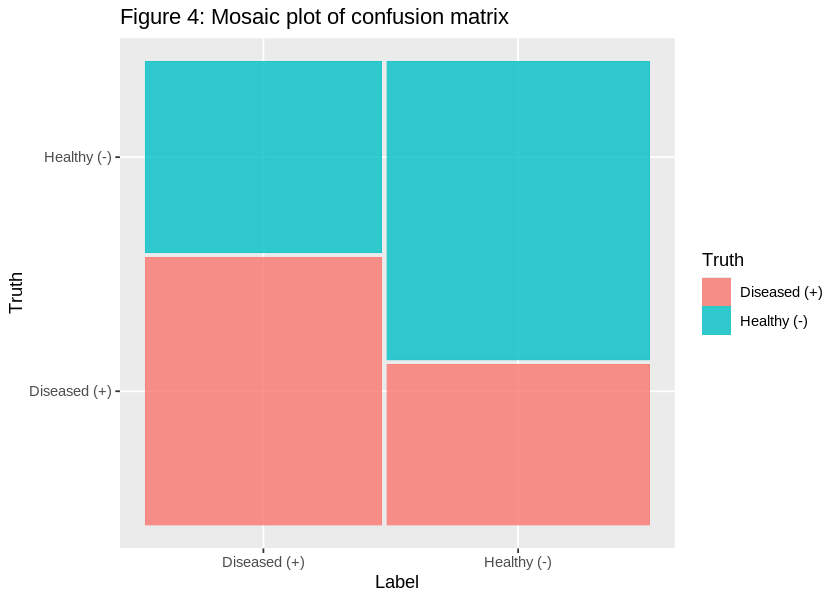

In [13]:
plot <- ggplot(data = tb) +
  geom_mosaic(aes(x = product(Truth, Label), fill = Truth)) + 
  labs(title = "Figure 4: Mosaic plot of confusion matrix")

options(repr.plot.width = 7, repr.plot.height = 5)
plot

# Discussion
* Summarize what you found
* Discuss whether this is what you expected to find
* Discuss what impact such findings could have
* Discuss what future questions this could lead to

# References
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).

Make sure to cite the source of your data as well.